In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
workers = 2

# Batch size during training
batch_size = 128
image_size = 64
inputchannel = 3  
latent = 100 
gen_feat = 64 
dis_feat = 64 
Num_GPU = 1 

  0%|          | 0/2753340328 [00:00<?, ?it/s]

Extracting ./data/fgvc-aircraft-2013b.tar.gz to ./data


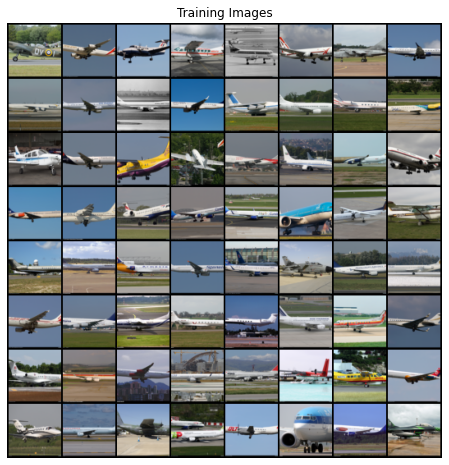

In [3]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

trainset = torchvision.datasets.FGVCAircraft(root='./data', 
                                        download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

#Device
device = torch.device("cuda:0" if (torch.cuda.is_available() and Num_GPU > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, Num_GPU):
        super(Generator, self).__init__()
        self.Num_GPU = Num_GPU
        self.main = nn.Sequential(
            nn.ConvTranspose2d( latent, gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feat * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_feat * 8, gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feat * 4, gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feat * 2, gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feat, inputchannel, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(Num_GPU).to(device)

#Select Device
if (device.type == 'cuda') and (Num_GPU > 1):
    netG = nn.DataParallel(netG, list(range(Num_GPU)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, Num_GPU):
        super(Discriminator, self).__init__()
        self.Num_GPU = Num_GPU
        self.main = nn.Sequential(
            nn.Conv2d(inputchannel, dis_feat, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat, dis_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 2, dis_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 4, dis_feat * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(Num_GPU).to(device)

#Select Device
if (device.type == 'cuda') and (Num_GPU > 1):
    netD = nn.DataParallel(netD, list(range(Num_GPU)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent, 1, 1, device=device)

real_label = 1
fake_label = 0

# Number of training epochs
num_epochs = 60 
# Learning rate 
lr = 0.0003
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, latent, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
  
        errD_fake = criterion(output, label)
 
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()

  
        netG.zero_grad()
        label.fill_(real_label)  

        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/60][0/53]	Loss_D: 1.8949	Loss_G: 7.8385	D(x): 0.5333	D(G(z)): 0.6049 / 0.0007
[0/60][50/53]	Loss_D: 0.6824	Loss_G: 13.4099	D(x): 0.7593	D(G(z)): 0.0000 / 0.0000
[1/60][0/53]	Loss_D: 1.7208	Loss_G: 17.5814	D(x): 0.4872	D(G(z)): 0.0001 / 0.0001
[1/60][50/53]	Loss_D: 0.6905	Loss_G: 7.6554	D(x): 0.9390	D(G(z)): 0.3841 / 0.0010
[2/60][0/53]	Loss_D: 1.1429	Loss_G: 13.7457	D(x): 0.9405	D(G(z)): 0.4980 / 0.0000
[2/60][50/53]	Loss_D: 0.5616	Loss_G: 5.5236	D(x): 0.8244	D(G(z)): 0.2106 / 0.0061
[3/60][0/53]	Loss_D: 0.7322	Loss_G: 4.2496	D(x): 0.6661	D(G(z)): 0.1302 / 0.0229
[3/60][50/53]	Loss_D: 1.7597	Loss_G: 2.4446	D(x): 0.2870	D(G(z)): 0.0046 / 0.1636
[4/60][0/53]	Loss_D: 0.3648	Loss_G: 3.9371	D(x): 0.8348	D(G(z)): 0.0876 / 0.0376
[4/60][50/53]	Loss_D: 0.8602	Loss_G: 5.8626	D(x): 0.5668	D(G(z)): 0.0070 / 0.0187
[5/60][0/53]	Loss_D: 1.0493	Loss_G: 1.8279	D(x): 0.4824	D(G(z)): 0.0153 / 0.2352
[5/60][50/53]	Loss_D: 0.5638	Loss_G: 3.1810	D(x): 0.7037	D(G(z)): 0.0691 / 

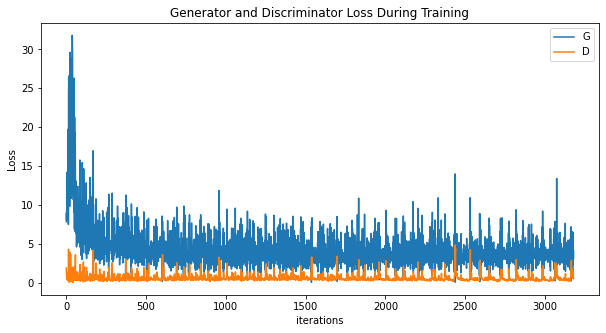

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

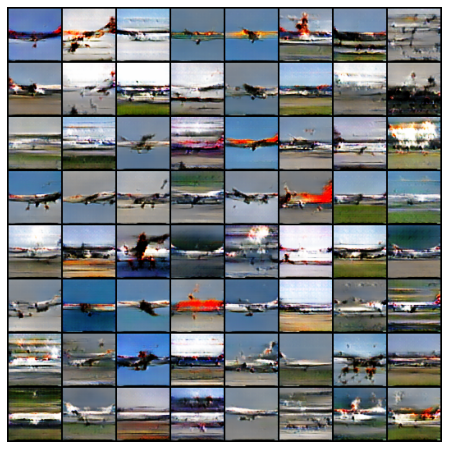

In [12]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

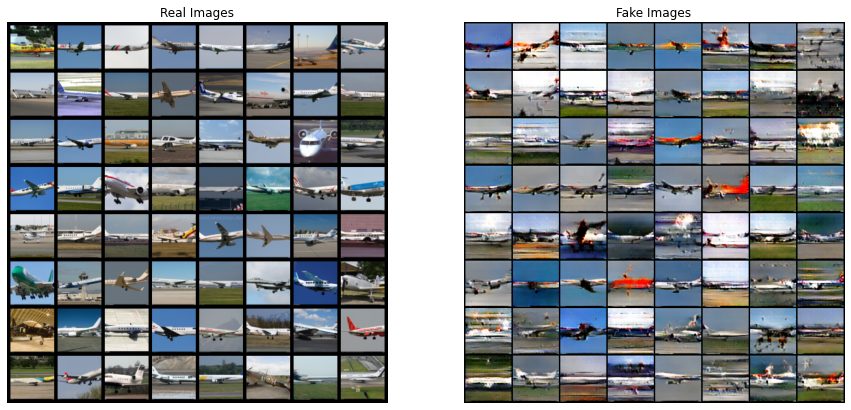

In [13]:
real_batch = next(iter(dataloader))

#Real Planes
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

#Fake Planes
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()